In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
#import pylab 
#from scipy import signal

import time # permite marcar o tempo de execução

In [56]:
start_time = time.time()

# reduz o samplig frequency 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 10
sampling_freq=50000/ratio # a ser usado no fft
skip=[i for i in range(0,250000) if i%ratio] # poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão

signals = pd.read_csv('mafaulda/imbalance/10g/61.8496.csv', header=None, 
                      names=['tachometer','ac1rad','ac1ax','ac1tg','ac2rad','ac2ax','ac2tg','microphone'],
                      skiprows=skip)
signals_fft = signals.apply(np.fft.rfft, axis=0)
signals_fft = signals_fft.apply(np.abs)
signals_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0]) # a frequência de Nyquist é sampling_freq/2

end_time = time.time()

print("Sinal com shape {} obtido em {} segundos".format(signals.shape, end_time-start_time))
print("a frequência de aquisição foi reduzida para {} Hz".format(sampling_freq))

Sinal com shape (25000, 8) obtido em 0.20201635360717773 segundos
a frequência de aquisição foi reduzida para 5000.0 Hz


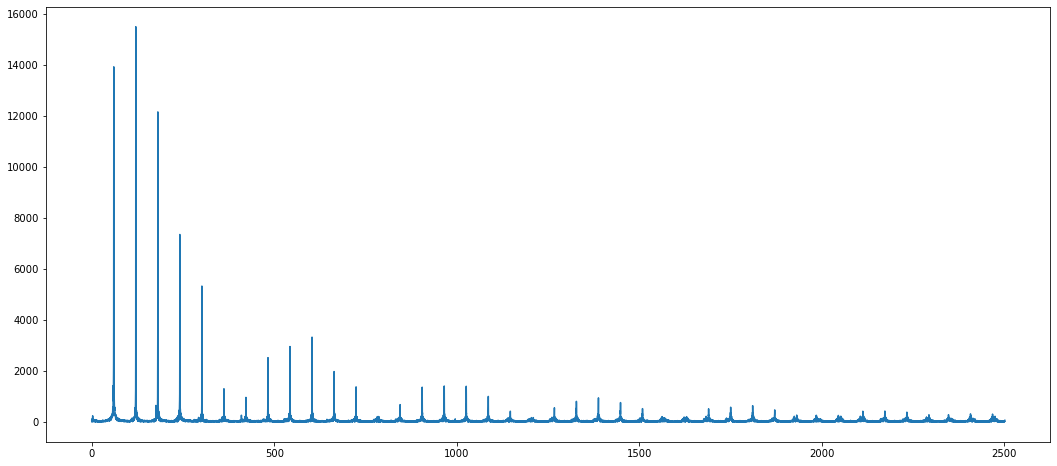

In [57]:
freq_axis = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0]) # a frequência de Nyquist é sampling_freq/2

plt.plot(signals_fft['freq_ax'], signals_fft['tachometer'])
plt.show()

In [58]:
#obtenção do valor da fundamental
fft_df = signals_fft['tachometer'].copy()
candidates = [0, 0, 0]
for i in range(3):
    index = fft_df.argmax()
    candidates[i] = signals_fft.freq_ax[index]
    for j in range(-2,3):
        fft_df[index+j] = 0
        
fundamental = min(candidates)
fundamental

60.42416

In [59]:
# extraindo valores no primeiro harmônico
index = signals_fft.index[signals_fft['freq_ax'] == fundamental]
print(index)
signals_fft.iloc[index]

Int64Index([302], dtype='int64')


,tachometer,ac1rad,ac1ax,ac1tg,ac2rad,ac2ax,ac2tg,microphone,freq_ax
302,"13,918.872","6,404.967","14,266.636","2,226.166",431.710,105.113,"5,912.464",276.229,60.424


In [60]:
# no segundo
index_2 = signals_fft.index[signals_fft['freq_ax'] == 2*fundamental]
print(index)
signals_fft.iloc[index_2]

Int64Index([302], dtype='int64')


,tachometer,ac1rad,ac1ax,ac1tg,ac2rad,ac2ax,ac2tg,microphone,freq_ax
604,"3,814.022",138.299,107.620,56.569,38.570,7.730,"1,026.197",23.875,120.848


In [61]:
# extraindo de outro modo
signals_fft.iloc[index*2]

,tachometer,ac1rad,ac1ax,ac1tg,ac2rad,ac2ax,ac2tg,microphone,freq_ax
604,"3,814.022",138.299,107.620,56.569,38.570,7.730,"1,026.197",23.875,120.848


In [62]:
# de modo específico
float(signals_fft.ac1rad.iloc[index*2].values.astype(np.float))

138.2986771915547

In [63]:
# gerando dicionário
first_h = signals_fft.iloc[index].to_dict('records')[0]
first_h.pop('tachometer')
first_h.pop('freq_ax')
first_h

{'ac1rad': 6404.9667903494765,
 'ac1ax': 14266.636365129269,
 'ac1tg': 2226.165711903757,
 'ac2rad': 431.71042978793713,
 'ac2ax': 105.11275624147058,
 'ac2tg': 5912.464178014923,
 'microphone': 276.22905371381125}

In [64]:
# adicionando sulfixo às chaves do dicionário
{k+'_1h': v for k, v in first_h.items()}

{'ac1rad_1h': 6404.9667903494765,
 'ac1ax_1h': 14266.636365129269,
 'ac1tg_1h': 2226.165711903757,
 'ac2rad_1h': 431.71042978793713,
 'ac2ax_1h': 105.11275624147058,
 'ac2tg_1h': 5912.464178014923,
 'microphone_1h': 276.22905371381125}

## Análise exploratória dos sinais

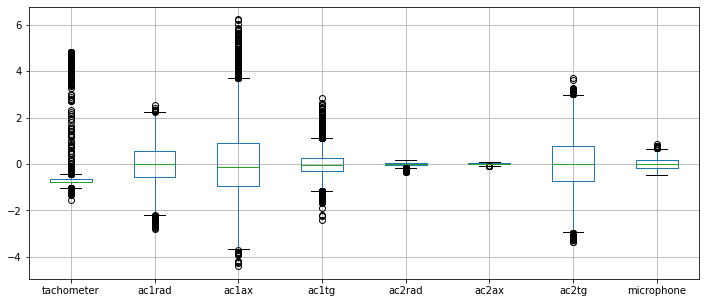

In [65]:
signals.boxplot(figsize=(12,5))

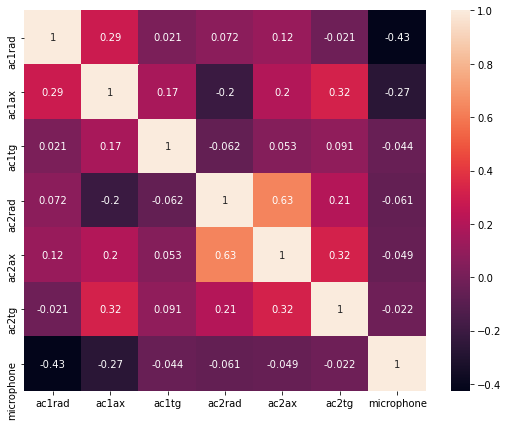

In [66]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(signals.iloc[:,1:].corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E43395E970>,
      dtype=object)

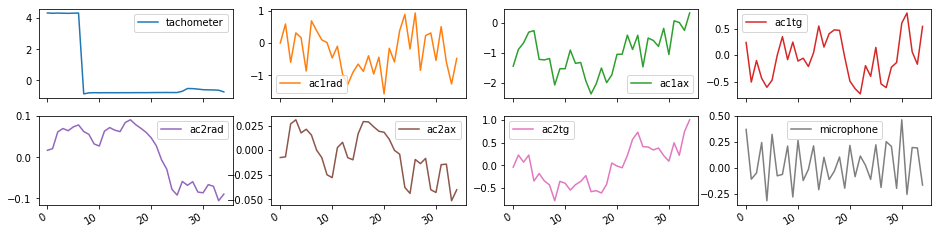

In [67]:
#signals.loc[:300,['ac1rad','ac1ax','ac1tg','tachometer',
#                  'ac2rad','ac2ax','ac2tg','microphone']].plot(subplots=True, layout=(2,4), figsize=(16,4))
signals.loc[:34].plot(subplots=True, layout=(2,4), figsize=(16,4))

In [68]:
#import simpleaudio as sa
from IPython.display import Audio, display
display(Audio(signals['tachometer'], rate=1000))
display(Audio(signals['microphone'], rate=1000))
display(Audio(signals['ac1rad'], rate=1000))
display(Audio(signals['ac1ax'], rate=1000))
display(Audio(signals['ac1tg'], rate=1000))
display(Audio(signals['ac2rad'], rate=1000))
display(Audio(signals['ac2ax'], rate=1000))
display(Audio(signals['ac2tg'], rate=1000))

## Máquina de análise de FFT

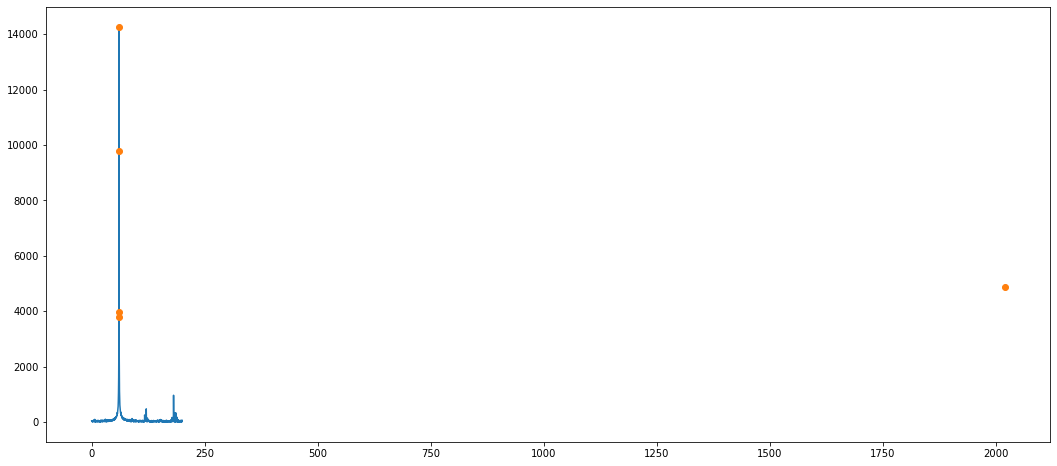

,freq,harmonic,amplitude
4,60.024,0.993,"3,800.319"
1,60.224,0.997,"9,798.210"
0,60.424,1.000,"14,266.636"
3,60.624,1.003,"3,958.817"
2,"2,020.408",33.437,"4,882.395"


In [69]:
real_fft = signals_fft['ac1ax'].values

num_max = 5 # limiar de seleção
temp = np.argpartition(-real_fft, num_max) # ordenando parte dos sinais
biggest_args = temp[:num_max] # extraindo os índices dos maiores valores de amplitude

greatest_values = pd.DataFrame({'freq':signals_fft.freq_ax[biggest_args], 
                                'harmonic': signals_fft.freq_ax[biggest_args]/fundamental,
                                'amplitude':real_fft[biggest_args]})

greatest_values.sort_values('amplitude', ascending=False, ignore_index=True, inplace=True) # organiza os índices decrescendo 
                                                                                           # amplitude do sinal

pd.options.display.float_format = '{:,.3f}'.format


# plot com zoom
max_freq = 200
plt.plot(freq_axis[:max_freq*5], real_fft[:max_freq*5], 
         list(greatest_values['freq']), list(greatest_values['amplitude']), 'o')
plt.show()

# mostra tabela
greatest_values.sort_values('harmonic') # exibe na ordem de HARMONICOS crescentes
#greatest_values  # exibe na ordem de AMPLITUDES decrescentes

## Teste: Análise de séries temporais

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [71]:
period = int(round(sampling_freq/fundamental))
period

83

<function matplotlib.pyplot.show(*args, **kw)>

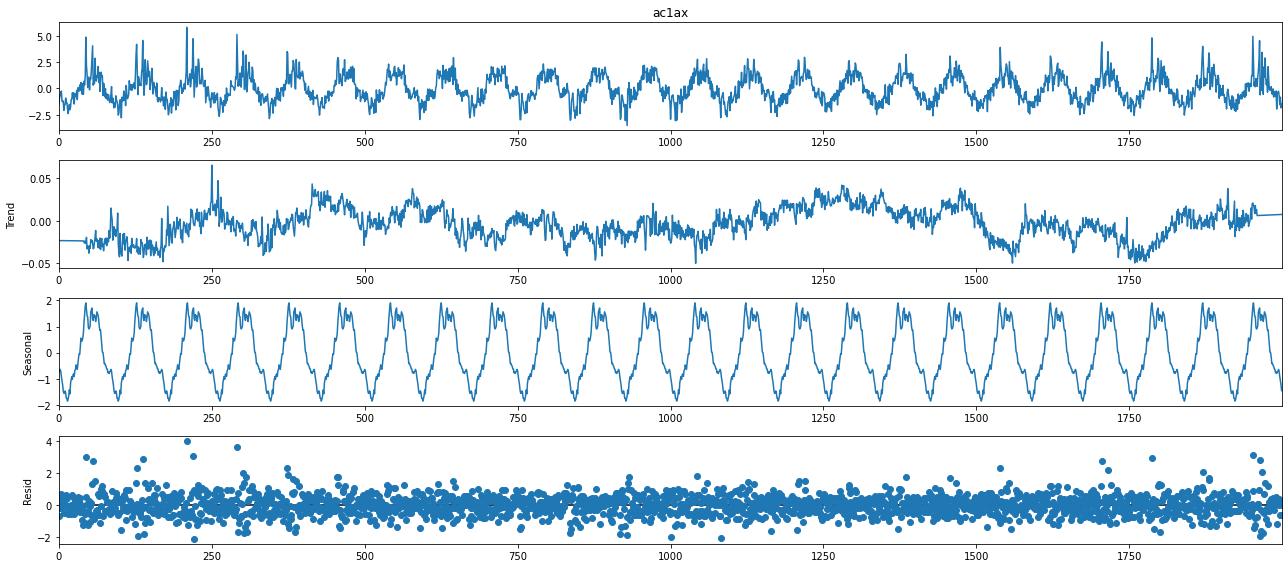

In [81]:
decomp_aditiva = seasonal_decompose(signals['ac1ax'][:2000], period=period, model='additive', extrapolate_trend='freq')
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomp_aditiva.plot()
plt.show

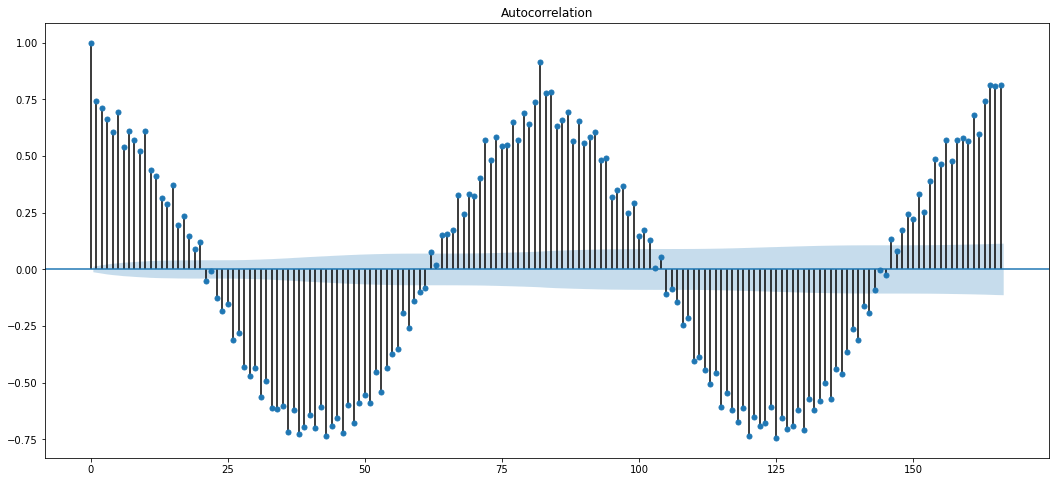

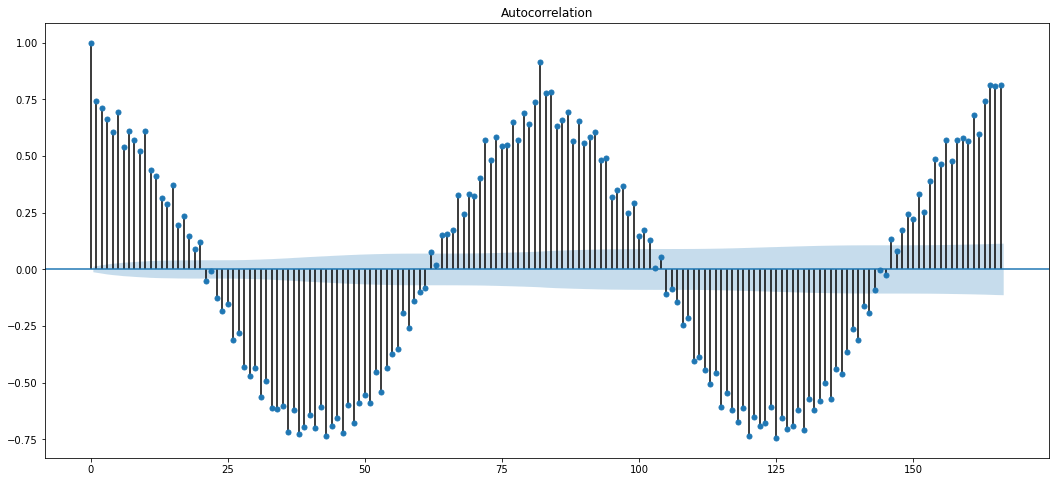

In [82]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(signals['ac1ax'], lags=2*period)

conclusão parcial: não dá para afirmar nada com esses modelos